In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-03 10:49:40.328361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 10:49:41.184924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
learning_rate = 1e-3
batch_per_file_size = 8
node_embedding_size = 12
layers = [128, 64, 32, 32]

dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-03 10:49:44.058093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 10:49:44.163591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 10:49:44.163834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='list_mle',
    l1_multiplier=1e-8,
    n_siblings=dataset.n_siblings
)

In [4]:
mlp.train(dataset, None)

2023-11-03 10:53:24.385744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-03 10:53:24.747812: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f135b6ee470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-03 10:53:24.748017: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-03 10:53:24.793542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-03 10:53:25.049002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-03 10:53:25.257955: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 10.439901 lr 0.00005
iteration 1000 training loss 9.706015 lr 0.00010
iteration 1500 training loss 9.295165 lr 0.00015
iteration 2000 training loss 9.261475 lr 0.00020
iteration 2500 training loss 9.837042 lr 0.00025
iteration 3000 training loss 9.743539 lr 0.00030
iteration 3500 training loss 8.267932 lr 0.00035
iteration 4000 training loss 8.853752 lr 0.00040
iteration 4500 training loss 9.656111 lr 0.00045
iteration 5000 training loss 8.128497 lr 0.00050
iteration 5500 training loss 7.8528314 lr 0.00055
iteration 6000 training loss 9.700933 lr 0.00060
iteration 6500 training loss 9.268948 lr 0.00065
iteration 7000 training loss 9.468697 lr 0.00070
iteration 7500 training loss 7.468856 lr 0.00075
iteration 8000 training loss 6.1991444 lr 0.00080
iteration 8500 training loss 6.793882 lr 0.00085
iteration 9000 training loss 6.9825077 lr 0.00090
iteration 9500 training loss 6.7792115 lr 0.00095
iteration 10000 training loss 7.129326 lr 0.00100
layout:nlp:rand

layout:nlp:random 0.8897774748149361
layout:nlp:default 0.48674705610421115
layout:xla:random 0.6751328621283734
layout:xla:default 0.28991426166737216
epoch 0, it 70000 validation loss -0.585
iteration 70500 training loss 4.4097123 lr 0.00086
iteration 71000 training loss 4.5404205 lr 0.00086
iteration 71500 training loss 4.197897 lr 0.00086
iteration 72000 training loss 4.829733 lr 0.00086
iteration 72500 training loss 6.138743 lr 0.00086
iteration 73000 training loss 5.5471215 lr 0.00085
iteration 73500 training loss 6.121609 lr 0.00085
iteration 74000 training loss 4.9172363 lr 0.00085
iteration 74500 training loss 4.201995 lr 0.00085
iteration 75000 training loss 4.762903 lr 0.00084
iteration 75500 training loss 4.878166 lr 0.00084
iteration 76000 training loss 4.781685 lr 0.00084
iteration 76500 training loss 4.3489823 lr 0.00084
iteration 77000 training loss 5.0706935 lr 0.00083
iteration 77500 training loss 5.1912537 lr 0.00083
iteration 78000 training loss 3.4812148 lr 0.00083

## Evaluate validation set

In [5]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

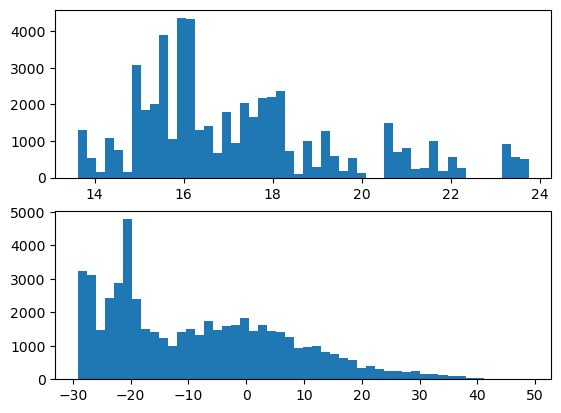

In [6]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [7]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:default:bert_multi_cased_L-12_H-7...,46,-29.139366,17.403856
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:default:small_bert_bert_en_uncase...,61,-28.890421,17.053982
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,10,-28.550730,16.523787
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train',b'layout:nlp:default:small_bert_bert_en_uncase...,9,-28.358072,15.192575
b'layout:nlp:default:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,10,-28.221882,18.141766
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,206,-27.918091,15.862122
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,26,-27.731417,16.076841
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train',b'layout:nlp:default:small_bert_bert_en_uncase...,96,-27.529600,17.015160
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-256_A-4_batch_size_32_train',b'layout:nlp:default:small_bert_bert_en_uncase...,39,-27.345245,15.298373


Text(0.5, 1.0, "b'layout:nlp:default:albert_en_xlarge_batch_size_16_test'")

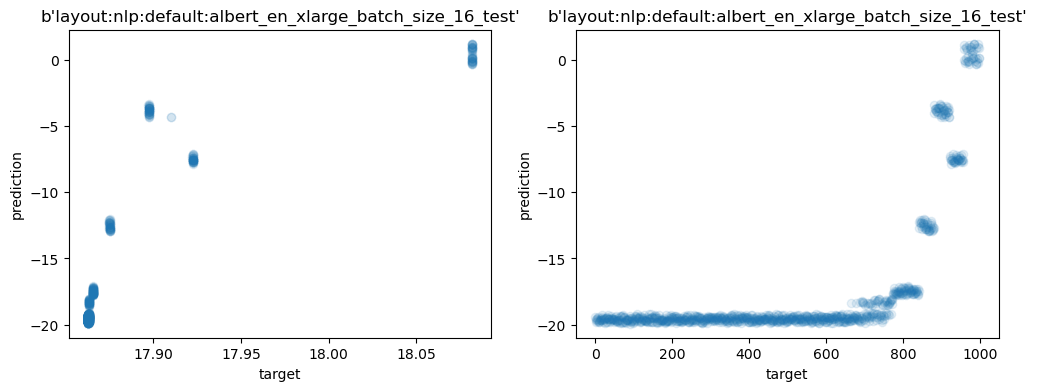

In [15]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

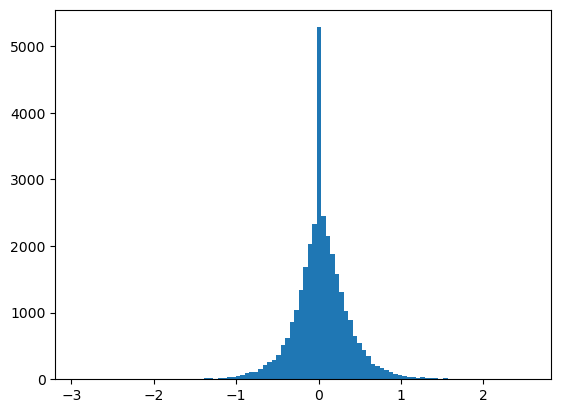

In [9]:
plt.hist(mlp.dense_layer_node_1.kernel.numpy().flatten(), bins=100);

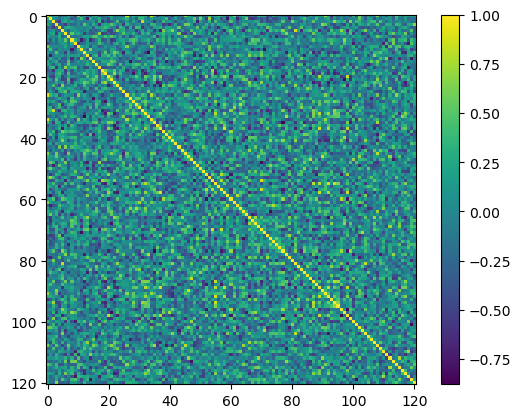

In [16]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
dots[34, 26]

In [ ]:
np.argsort(dots[26])

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
layout_ids = val_batch['layout_id']
config_descriptor = val_batch['node_descriptor']
valid_mask = val_batch['valid_nodes']
graph_descriptor = val_batch['graph_descriptor']

with tf.device('/cpu:0'):
    subset_info_str = tf.map_fn(
        lambda layout_id: tf.strings.reduce_join(
            tf.strings.split(layout_id, ":")[:3]),
        layout_ids
    )

subset_info = mlp.text_vectorization(subset_info_str)
subset_info = tf.expand_dims(subset_info, axis=-1)
subset_info = mlp.embedding_layer_subset_info(subset_info)
subset_info = subset_info[:, 0, :]

# for si, sn in zip(subset_info_str.numpy(), subset_info.numpy()):
#     print(si, sn)

node_operations = config_descriptor[:, :, -1]
config_descriptor = config_descriptor[:, :, :-1]
node_operations = tf.cast(node_operations, tf.int32)
# node_operations.shape == (batch_size, mask_max_len)                                                                                                                                 
node_embedding = mlp.embedding_layer_node_ops(node_operations)
# node_embedding.shape == (batch_size, mask_max_len, embed_len)
# np.unique(node_operations.numpy().flatten(), return_counts=True)

x = mlp.normalization_layer_config_nodes(config_descriptor)
normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, node_embedding], axis=-1)

x = mlp.dense_layer_node_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           
x = mlp.dense_layer_node_2(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           

# plt.hist(x.numpy().flatten(), bins=100);
float_mask = tf.sequence_mask(valid_mask, mlp.mask_max_len, dtype=tf.float32)
# (batch_size, n_config_nodes_upper_limit)                                                                                                                                            

float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask

x = tf.reduce_sum(x, axis=1)
#plt.subplot(2, 1, 1)
#plt.hist(x.numpy().flatten(), bins=100);

x = x / tf.expand_dims(tf.cast(valid_mask, tf.float32), axis=-1)
#plt.subplot(2, 1, 2)
#plt.hist(x.numpy().flatten(), bins=100);
for i, lid, gd, nd in zip(range(96), layout_ids.numpy(), graph_descriptor.numpy(), normal_graph_descriptor.numpy()):
    if i in [19]:
        print(i, gd[80:90], nd[80:90], lid)
x = tf.concat([x, normal_graph_descriptor, subset_info], axis=-1)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_1(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_2(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [17]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               1539;52923;2658;14622;47152;26074;54343;24707;...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  89239;39894;31015;89232;37669;74471;53664;6062...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              25535;7862;1196;8045;25696;7806;22819;10615;12...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      67502;67714;66005;39279;50335;83042;1898;34286...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     19550;15747;15725;15720;44328;36423;33894;3905...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      59153;20672;50732;50729;43036;70724;35375;2531...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     27282;14562;306;331;12486;26775;1199;1050;367;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [18]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:default:small_bert_bert_en_uncase...,24281,-27.375299,18.142185
1,b'layout:nlp:default:small_bert_bert_en_uncase...,23503,-24.919807,18.143459
2,b'layout:nlp:default:small_bert_bert_en_uncase...,12637,-11.805301,18.193163
3,b'layout:nlp:default:small_bert_bert_en_uncase...,1224,-27.616564,18.142120
4,b'layout:nlp:default:small_bert_bert_en_uncase...,4544,-27.804575,18.141916
...,...,...,...,...
53476,b'layout:nlp:default:small_bert_bert_en_uncase...,40831,-27.509670,16.078321
53477,b'layout:nlp:default:small_bert_bert_en_uncase...,50517,-26.338448,16.079334
53478,b'layout:nlp:default:small_bert_bert_en_uncase...,38178,-11.387341,16.146774
53479,b'layout:nlp:default:small_bert_bert_en_uncase...,28166,-26.699173,16.078224


In [19]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:default', 'layout:xla:default', 'layout:nlp:random',
       'layout:xla:random'], dtype=object)

In [20]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:nlp:default 0.48870744180714903
layout:xla:default 0.2499011384353083
layout:nlp:random 0.909373527138494
layout:xla:random 0.6685461629029853


In [21]:
np.mean([0.4185, 0.8167, 0.538, 0.2525])

0.506425

In [22]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                         -0.047726
b'layout:xla:default:unet_3d.4x4.bf16'                                                 -0.010756
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.253818
b'layout:xla:default:inception_v3_batch_128_train'                                      0.278850
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.311648
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.345306
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.379568
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train'     0.392643
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.398413
b'layout:xla:default:bert_pretraining.4x4.fp16'                                         0.430919
b'layout:nlp:default:small_

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [23]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:default:38524e2ff135ded55b5286407...,7,-21.941257
1,b'layout:nlp:default:38524e2ff135ded55b5286407...,13,-21.148251
2,b'layout:nlp:default:38524e2ff135ded55b5286407...,9,-21.819122
3,b'layout:nlp:default:38524e2ff135ded55b5286407...,6,-15.142557
4,b'layout:nlp:default:38524e2ff135ded55b5286407...,16,-21.840191
...,...,...,...
49997,b'layout:nlp:random:3a0c5517a87df8d82fd637b832...,981,10.033087
49998,b'layout:nlp:random:3a0c5517a87df8d82fd637b832...,996,27.196562
49999,b'layout:nlp:random:3a0c5517a87df8d82fd637b832...,989,26.875082
50000,b'layout:nlp:random:3a0c5517a87df8d82fd637b832...,968,20.966127


In [24]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    747;247;78;457;830;321;961;487;934;128;578;20;...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    17;252;536;11;476;438;487;669;483;562;645;431;...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    204;539;687;825;930;214;17;801;449;418;176;108...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    237;939;370;953;696;196;954;275;134;677;96;295...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    990;64;816;513;958;234;184;447;309;151;790;654...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    590;367;880;917;383;659;883;114;124;162;312;60...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    85;812;781;348;580;910;237;603;276;813;64;692;...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    767;885;398;236;224;383;634;108;717;75;193;217...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    761;135;679;84;328;622;932;37;777;231;613;570;...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [25]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_none_test_prediction_11_03_14_00.csv')